In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# Any results you write to the current directory are saved as output.

FileNotFoundError: [Errno 2] No such file or directory: 'input'

In [2]:
# common imports

import numpy as np
import json
import matplotlib.pyplot as plt


In [3]:
file = open('../input/ships-in-satellite-imagery/shipsnet.json')
dataset = json.load(file)
file.close()

In [4]:
dataset.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

In [5]:
# write data to numpy arrays
data = np.array(dataset['data']).astype('uint8')

In [6]:
data.shape

(4000, 19200)

In [7]:
# extract label data 

label_data = np.array(dataset['labels']).astype('uint8')

In [8]:
label_data.shape

(4000,)

In [9]:
# reshape data for visualization
channels = 3
width = 80
height = 80

X = data.reshape(-1, 3, width, height).transpose([0,2,3,1])
X.shape

(4000, 80, 80, 3)

### Sample Image

(80, 80, 3)


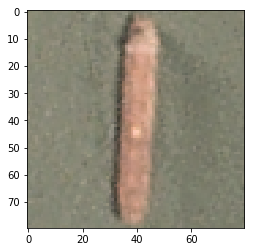

In [10]:
# check sample shape and plot
print(X[800].shape)
sample_pic = X[800]
plt.imshow(X[800])

In [11]:
type(sample_pic)

numpy.ndarray

### SKImage 

Convert RGB image to Grayscale

In [12]:
from skimage import color

In [13]:
sample_pic_gr = color.rgb2gray(sample_pic)

In [14]:
sample_pic_gr.shape

(80, 80)

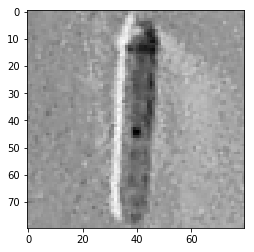

In [15]:
plt.imshow(sample_pic_gr)
plt.set_cmap('Greys')

In [16]:
# converting all images to greyscale. Output is a list

X_grey = [ color.rgb2gray(i) for i in X]

In [17]:
X_grey = np.array(X_grey)

In [18]:
X_grey.shape

(4000, 80, 80)

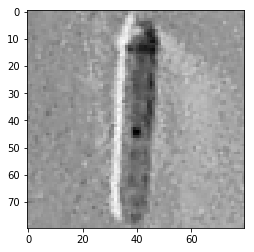

In [19]:
plt.imshow(X_grey[800])

In [20]:
label_data[800]


1

In [21]:
X_grey.shape

(4000, 80, 80)

In [22]:
X_grey[:2]

array([[[0.35466902, 0.37622627, 0.38435216, ..., 0.38464275,
         0.36222941, 0.36224431],
        [0.37903176, 0.3868749 , 0.38268549, ..., 0.43422431,
         0.37679961, 0.37455961],
        [0.38406941, 0.39528353, 0.37063804, ..., 0.36139608,
         0.38604157, 0.38799098],
        ...,
        [0.37370353, 0.37258745, 0.38799098, ..., 0.37539294,
         0.36671647, 0.37931451],
        [0.37484235, 0.37539294, 0.38406941, ..., 0.38406941,
         0.38323608, 0.38632431],
        [0.3751102 , 0.38378667, 0.38295333, ..., 0.38100392,
         0.38520824, 0.38632431]],

       [[0.32439765, 0.32075882, 0.28995176, ..., 0.32606431,
         0.32860196, 0.33671294],
        [0.30816078, 0.31319843, 0.30647137, ..., 0.32689765,
         0.32860196, 0.34400549],
        [0.31319843, 0.30143373, 0.28714627, ..., 0.33782902,
         0.33587961, 0.34792706],
        ...,
        [0.30084549, 0.29047961, 0.2787149 , ..., 0.28713137,
         0.28713137, 0.26697294],
        [0.2

## Keras and Tensorflow

In [23]:
import tensorflow as tf
from tensorflow import keras

In [24]:
print(tf.__version__,"|", keras.__version__)

2.0.0 | 2.2.4-tf


### Checking GPU availability

In [25]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [26]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18417939021664885370
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2655586252229761886
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 650263366814835582
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15876469556
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9645687271999977374
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [27]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

### Keras Model

In [28]:
tf.random.set_seed(42)
np.random.seed(42)

In [29]:
# Split dataset into train, valid and test sets.
from sklearn.model_selection import train_test_split

In [30]:
# split training, validation and test sets

X_train_full, X_test, y_train_full, y_test = train_test_split(X_grey, label_data, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [31]:
# Standardize features by subtracting the mean and scaling to unit variance

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)

X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

### A Keras sequential model with hidden layers.

* Kernel/Weight Initialization : Lecun_normal
* Activation function in hidden layers: SELU
* Optimizer: Nadam
* Loss: Binary_Crossentropy
* Dropout: 0.3

This is just a simple implementation.

In [32]:
keras.backend.clear_session()

In [33]:
# Model

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[80,80]))
model.add(keras.layers.Dense(300, activation='selu',
                             kernel_initializer='lecun_normal'))

for layer in range(9):
#     model.add(keras.layers.Dropout(0.3)) 
    model.add(keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'))

# output layer
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               1920300   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [35]:
# compile

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Nadam(decay=1e-4),
              metrics=["accuracy"])

In [36]:
# train
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=40,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[early_stop])

Train on 2250 samples, validate on 750 samples
Epoch 1/40
2250/2250 [==============================] - 5s 2ms/sample - loss: 0.4571 - accuracy: 0.8164 - val_loss: 0.2897 - val_accuracy: 0.8747
Epoch 2/40
2250/2250 [==============================] - 1s 308us/sample - loss: 0.2090 - accuracy: 0.9213 - val_loss: 0.4803 - val_accuracy: 0.7853
Epoch 3/40
2250/2250 [==============================] - 1s 320us/sample - loss: 0.1626 - accuracy: 0.9436 - val_loss: 0.1867 - val_accuracy: 0.9440
Epoch 4/40
2250/2250 [==============================] - 1s 324us/sample - loss: 0.1784 - accuracy: 0.9387 - val_loss: 0.1823 - val_accuracy: 0.9293
Epoch 5/40
2250/2250 [==============================] - 1s 311us/sample - loss: 0.1208 - accuracy: 0.9627 - val_loss: 0.1971 - val_accuracy: 0.9293
Epoch 6/40
2250/2250 [==============================] - 1s 315us/sample - loss: 0.0723 - accuracy: 0.9782 - val_loss: 0.2228 - val_accuracy: 0.9227
Epoch 7/40
2250/2250 [==============================] - 1s 317us/sa

In [37]:
model.evaluate(X_test_scaled, y_test, verbose=0)

[0.17195483562350272, 0.953]

### END